# 数据分析技巧篇（一）：一个查询统计的例子

## 任务目标

假设我们有一个统计每一个人每天发了多少条消息的记录，数据格式如下：

date | user | num |
-|------
2016-01-01 | user2 | 54
2016-01-01 | user5 | 45
2016-01-02 | user1 | 8
2016-01-02 | user3 | 72
2016-01-02 | user7 | 34
......| .... | ....
2016-12-31 | user4 | 35
2016-12-31 | user2 | 45
2016-12-31 | user1 | 78
2016-12-31 | user1 | 54
2016-12-31 | user1 | 77

我们现在需要统计在每一天累积有多少人有过发言。

## Pandas实现

我们需要用到的Pandas相关库包括NumPy、Pandas、Matplotlib。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

我们先生成一组模拟数据。date和user两个变量我们用整数代替以方便生成，date取100天，user取1000个，num的范围取1到50。一个小提醒，Python里类似于range的生成逻辑，大部分都是取前不取后，所以我写的是101，1001和51。这里为了防止date和user重复，我们除去一下重复值。

In [2]:
df = pd.DataFrame({
    'date':np.random.randint(1,101,size=10000),
    'user':np.random.randint(1,1001,size=10000),
    'num':np.random.randint(1,51,size=10000),
}).drop_duplicates(['date','user'])

首先我们来想想可能需要的操作。提到每一天，我们想到groupby或者层次化索引；提到“累积”，可以想到cumsum()、cumprod()这类操作，这里cumsum()很可能用上；提到统计个数，我们可以用count()来数，也可以生成一列虚拟变量然后用sum()加总。注意，这里只是说“可能”，我们如果采用不同的操作路径，很可能有些方法是用不上的，或者我们需要补充一些别的方法。

然后我们来梳理怎么实现到这个具体过程。我们需要的一个输出结果是一个每天有多少人累积发言过。比如：

date | num
--|------
2016-01-01 | 2
2016-01-02 | 5
.. | ..
2016-12-30 | 1000
2016-12-31 | 1000

为了这个输出结果，我们需要知道哪些人在这个天有过发言，然后数一下个数。数个数容易，怎么知道哪些人在这天发过言呢？我们有了每个人在这天发言的记录，那么如果到这一天为止他说过话，num就大于0。这里就可以使用cumsum()操作了。但是使用cumsum()操作，我们需要让每个人成为一列，每个人成为一行，这样我们需要把原始的长型(long)数据整理成宽型(wide)数据，这样我们需要pivot()操作，就不再需要groupby操作了。

下面我们开始操作。首先我们把长型数据转换成宽型数据：

In [3]:
tmp = df.pivot('date','user','num')
tmp.head()

user,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
date,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,14.0,NaN,NaN,NaN,NaN,47.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,44.0,NaN,NaN,41.0,NaN,NaN,10.0,NaN,NaN
4,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0
5,38.0,NaN,NaN,NaN,NaN,NaN,NaN,46.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


pivot的三个参数非常直观，第一个参数是哪一列的值用来做行索引（date），第二个参数是哪一列的值用来做列索引（user），第三个参数是里面的值填什么。这样我们就把数据成功转化出来了，但是我们可以看到，这里面大半是缺失值。为了方便加总，我们把NaN填充成0。我们使用replace()操作。这里注意，因为NaN是NumPy定义的一个特殊的对象，所以我们使用np.nan。

In [4]:
tmp = tmp.replace(np.nan,0)
tmp.head()

user,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
date,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,14.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,44.0,0.0,0.0,41.0,0.0,0.0,10.0,0.0,0.0
4,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0
5,38.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


下面我们来加总一下每个人的累积发言数。

In [5]:
tmp = tmp.cumsum()
tmp.head()

user,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
date,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,14.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,14.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,...,0.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,14.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,...,0.0,44.0,38.0,0.0,41.0,0.0,0.0,10.0,0.0,0.0
4,0.0,0.0,36.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,...,0.0,44.0,38.0,0.0,41.0,0.0,0.0,10.0,0.0,25.0
5,38.0,0.0,36.0,0.0,0.0,0.0,0.0,93.0,0.0,0.0,...,0.0,44.0,38.0,0.0,41.0,0.0,0.0,10.0,0.0,25.0


为了方便加总，我们把大于0的数处理成1。这里要对整个DataFrame每一个元素操作，所以使用applymap()操作传入一个lambda函数。get_dummies()操作是针对分类变量的，不能直接对浮点数操作，我们也可以先把浮点数转化成分类变量之后使用。

In [6]:
tmp = tmp.applymap(lambda x:1 if x>0 else 0)
tmp.head()

user,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
date,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,1,1,0,1,0,0,1,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,1,1,0,1,0,0,1,0,1
5,1,0,1,0,0,0,0,1,0,0,...,0,1,1,0,1,0,0,1,0,1


然后我们对每一行加总，这里要设置一下sum()的axis。

In [7]:
tmp = tmp.sum(axis=1)
tmp.head()

date
1     88
2    186
3    268
4    339
5    405
dtype: int64

我们可以画出一个图。

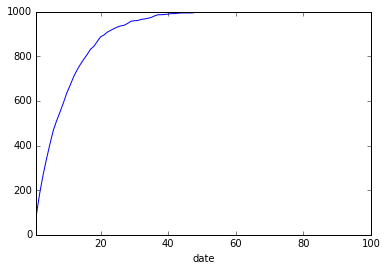

In [8]:
% matplotlib inline
tmp.plot()

到这里整个过程就结束了，我们可以把整个过程写成一行。

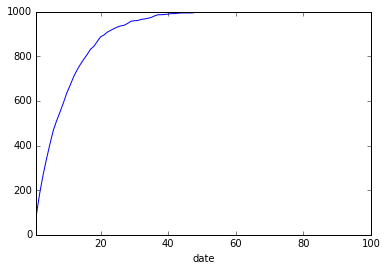

In [9]:
df.pivot('date','user','num').replace({np.nan:0}).cumsum().applymap(lambda x: 1 if x>0 else 0).sum(axis=1).plot()

## SQL实现

我们假设输入数据集叫 `tmp.t_msg_count`，列名分别是`date`、`user`、`num`。重复上面的思路非常麻烦，我们可以使用简单粗暴的直接统计方法来尝试。

首先我们生成一个所有天的临时表。

```
create table tmp.t_date as
select distinct date as date
from tmp.t_msg_count
```

然后我们生成一个笛卡尔乘积，对每天做groupby分组，用where取这天之前的天，取这天以前所有非重复的人即可。

```
select b.date as date,
   count(distinct user) as cnt
from tmp.t_msg_count as a, tmp.t_date as b
where a.date<=b.date
group by b.date
```

我们也可以把过程合并成一步。
```
select b.date as date,
   count(distinct user) as cnt
from tmp.t_msg_count as a, (
  select distinct date as date
  from tmp.t_msg_count
) as b
where a.date<=b.date
group by b.date
```



## 讨论

从这个过程中，我们可以看到SQL的这种批处理操作，在面对结构化数据的时候，比面向数组的Pandas要简单不少。当然这不是全部的情况，SQL也有很多支持的不好的操作，比如reshape等，所以具体使用什么还是取决于具体问题。

虽然面向数组的Pandas方法在这个问题中显的略复杂，但是事实上这个思路是可以用来解决一类问题的。本文示例的这个问题恰好是一个大项目的一个小小的分析项目，这种相对通用的思路实际上为我在后续分析其他统计特征的时候提供了极大的便利。从前面的过程中我们可以看到，我们可以得到某个人每天的发言矩阵，如果需要做模型，可以在后续过程中直接使用；如果我们想得到累和，也可以直接在中间过程中得到。甚至于我们可以变化一点点操作，得到平均值、中位数、方差等。比如说我们想得到一个每天的平均发言次数，我们可以这么修改：

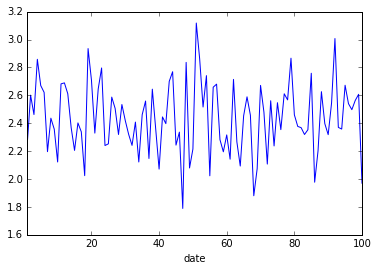

In [43]:
df.pivot('date','user','num').replace({np.nan:0}).mean(axis=1).plot()

那么我们有没有办法结合Pandas和SQL的优点呢？当然可以。在工程实践里面，我们通常情况下会从数据库中取原始数据，这个时候我们可以先用SQL查询做第一次精简，导入Pandas以后再做第二次精简和各种计算。如果原始数据是文本文件，并且已经被导入Pandas，我们还有一个可以让Pandas做SQL查询的工具`pandasql`。这里简单示例一下用法。注意，`pandasql`使用的是SQLite的语法，因此可能和其他的SQL实现有出入。

我们导入pandasql，并且按照官方文档（https://pypi.python.org/pypi/pandasql ）的方法做初始化设置。pandasql会自动识别DataFrame。

In [11]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

然后我们写一下SQL查询语法

In [41]:
query = """
select b.date as date,
   count(distinct user) as cnt
from df as a, (
  select distinct date as date
  from df
  order by date
) as b
where a.date<=b.date
group by b.date
"""

查询，返回一个新的DataFrame。为了方便展示，我们只显示前几行。

In [42]:
pysqldf(query).head()

,date,cnt
0,1,88
1,2,186
2,3,268
3,4,339
4,5,405


画个图验证一下。

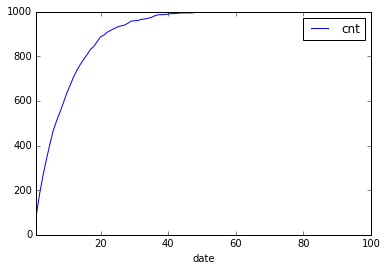

In [44]:
pysqldf(query).plot(x='date',y='cnt')

最后补充一下，在工程开发中，我们并不需要一味追求“最好”的方法，对自己来说最流畅的方法就是最好的，工程开发中，保持开发效率和可维护的平衡才是第一位的，晦涩难懂的操作不是最好的，简明清楚、容易实现的才是最好的。